<style>
r { color: Red }
o { color: Orange }
g { color: Green }
b { color: LightBlue}
w { color: White}
</style>

# **Mobile Robotics Presentation Group 16**
EPFL Course MICRO-452, fall 2023
- Gilles Regamey 296642
- Julien Droulet SCIPER
- Tom Rathjen    SCIPER
- Aubin Sabatier SCIPER

## Table of content
-   [Choices](#choices)
    - environement
    - filter
    - navigation
-   [Modules](#modules)
    - Vision
    - Global Navigation
    - Local Navigation
    - Filtering
    - Motion Control
-   [Demonstration](#demo)
    - setup
    - loop
-   [Results](#results)
    - encountered problems
    - performance
    - improvements



<a id="choices"></a>
# Choices taken
The project called for a environement map to navigate with fixed and un-planned obstacles to a destination point from any point. Fixed obstacles are constant trough the navigation and the robot can't use its sensor to detect them, they are only given by the camera at the start. Un-planned obstacles are detected only by the robot and can move at any time during navigation. 

## Environement
For the sake of simplicity, our map is a white A0 paper sheet with 4 <b>blue</b> box (4x4cm) at the corners. The Fixed obstacles are black pieces of cardboard of any shape. Mobile obstacles are <w>white</w> boxes of 4x4x4 cm 3d printed in PLA to have a more consistent reading with the proximity sensors. The robot is fitted with a paper hat with <r>red</r> circles in a isosceles triangle pattern for position and orientation. The destination is a big green circle 8cm in diameter. The image of the map is reframed to have a resolution of $1 \frac{px}{mm}$.

Below a theoretical map image before processing.

<img src="src\Vision\test_data\test_map.png" />

The fixed obstacles are abstracted in two ways for two different purposes:
- For Global navigation: occupancy grid of constant size.
- For Local navigation: polygonal contour approximation.
We'll see why in the modules descriptions.  

## Filtering
The camera gives us a pretty good estimation for the position and orientation of the robot, but we need to be able to navigate without it as somes frames can extract the position because of the changes in illumination or simply if the robot can't be seen. 

<r>**WHY A KALMAN ? - #[TODO]AUBIN**</r>

## Global navigation
For the path planning we choose the A\* Algorithm with the occupancy grid given by the vision module.
To have a margin to the obtacle 

<r>**why A\* - #[TODO]JULIEN**</r>

## Local navigation
Mobile and un-planned obstacles have to be detected and avoided. We choose to use a neural network system to be more robust to non standard obstacles. 

<r>**why neural #[TODO] TOM**</r>

<a id="modules"></a>
# Modules description

## **Vision**
The vision module is responsible for everything concerning the camera and vizualization.
Most importantly it has to detect the robot, the obstacles, the destination and the map correctly.
Visualization functions have been more of a tool to see and debug outputs of detection.
As our map elements are color based, we use the HLS (Hue Luminosity Saturation) encoding of the image to have a better chance at detecting color patches.
We use the opencv library extensively because of the blazingly fast parallel computation and all the usefull tools for detection and image processing.

### map detection
In the setup phase, we need to calibrate the camera to reframe the map in a consitant way to give a baseline for other functions. Opencv has a very usefull function called `warpPerspective()` just for that, we just need to give it the <w>warp matrix</w> and desired output shape. The function `vision.get_warp()` gives us this <w>warp matrix</w> from the image using the algorithm below and with the help of smaller functions called `reorder_border()`, `blob_point_list()` and another opencv function to compute the matrix from reference points `getPerspectiveTransform`. Note that this is not functionnal code, the real function and subsequent vision function can be found in `/src/vision.py`.

```python
def get_warp(capture_stream,ROI,padding,number_of_samples):
    while valid_samples < number_of_samples:
        frame = capture_stream.read()
        hsl_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS_FULL)
        nb_points,point_list = blob_point_list(Blue,CORNER_BLOB_FILT,CORNER_BLOB_VAL)
        if nb_points == 4:
            isvalid,ord_list = reorder_border(point_list)
            if isvalid:
                corners[:,:,smp] = ord_list
                valid_samples += 1
    avgCorn = mean(corners) 
     
    return cv2.getPerspectiveTransform(avgCorn,Sheetpts)
```
The `reorder_border()` function is just ordering the points relative to the center of the polygon they form (above/under,left/right) in order to give a consistant list of point for the averaging process.

Note that no action is taken for tangential and radial distortions. Opencv provides function for camera calibration and undistortion methods that need a calibration pattern (Charuco boards). We tried to use it but coulnd't get consitant camera matrix, it just made things worse most of the time so we decided to drop the idea knowing that robot position detection was good enough at our scale.

### Obstacle detection and abstraction

For the grid map of the obstacles we just apply a threshold to a scaled down filtered grayscale image of the map using opencv functions. You can also add a safe radius around obstacles using dilatation. 

```python
def get_grid_fixed_map(frame,shape,tresh=50,kernsz=5,robrad=80):
    kernel = np.ones((kernsz,kernsz),np.uint8)
    pxmap = cv2.inRange(frame,(0,0,0),(tresh,tresh,tresh))
    pxmap = cv2.morphologyEx(pxmap,cv2.MORPH_OPEN,kernel)
    if robrad != 0:
        safecircle = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(robrad,robrad))
        pxmap = cv2.dilate(pxmap,safecircle)
    temp = cv2.resize(pxmap, shape, interpolation=cv2.INTER_LINEAR)
    _,output = cv2.threshold(temp,10,1,type=cv2.THRESH_BINARY)
```

For the polygonal abstraction of the obstacles, we use opencv `findContours()` and `approxPolyDP()` to get an array of obstacles described as arrays of corner points.


```python
def get_obstacles(frame,tresh=50,eps=10,robrad=0):
    kernel = np.ones((5,5),np.uint8)
    pxmap = cv2.inRange(frame,(0,0,0),(tresh,tresh,tresh))
    pxmap = cv2.morphologyEx(pxmap,cv2.MORPH_OPEN,kernel)
    if robrad != 0:
        safecircle = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(robrad,robrad))
        pxmap = cv2.dilate(pxmap,safecircle)
    contp,hier =  cv2.findContours(pxmap,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    obstacles = []
    for cont in contp:
        cont = np.array(cont,dtype=np.float32).reshape((-1,2))
        scont = cv2.approxPolyDP(cont,eps,True)
        obstacles.append(scont)
    return obstacles
```


## **Module**

### submodule 1
description of module 

equation inline : $\alpha + \beta = e$

equations by line
\begin{equation}
S(\omega)=1.466\, H_s^2 \frac{\omega_0^5}{\omega^6} \exp\Bigl[-3^{\frac{\omega}{\omega_0}}\Bigr]^2
\end{equation}

### submodule 2
description of module 
code implementation
```python
if (goodboy):
    reward += 1
else:
    reward = 0
```


<a id="demo"></a>
# Demontration

In [1]:
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import opencv_jupyter_ui as jcv2

## Custom Libraries 
from src.Motion_Control import thymio as th
from src.Global_Nav import helpers_global as gn
from src.Vision import vision as vs
from src.Local_Nav import psymap as pm  
from src.Local_Nav import local_navigation as ln
from src.Filtering import filtering
from src.Motion_Control import PID



In [2]:
## Constant 
REFRAME = True 
TS =0.01
EPSILON_ANGLE= np.pi/10
VISUALIZE = True
MAP_SHAPE_MM = (1000,700)
MAP_SHAPE_CELL = (50,35)
ROBROAD = 80
SIMPLIFY = 0.8
SAVE_VIDEO = True

In [3]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node() #_ = protected #__ = private = shouldn't access node outside of the class
await node.lock()


cap = cv2.VideoCapture(0)

if SAVE_VIDEO:
    videosaver = cv2.VideoWriter('VideoG16.avi',  cv2.VideoWriter_fourcc(*'MJPG'), 10, MAP_SHAPE_MM) 

Searching for destination...
Found destination Point at [168 571] [mm] (8, 7) [cells]
Searching for Robot...
Robot found at [882 477] [mm], -2.525295716193722 [rad]
Initial Map:
Map with optimal path


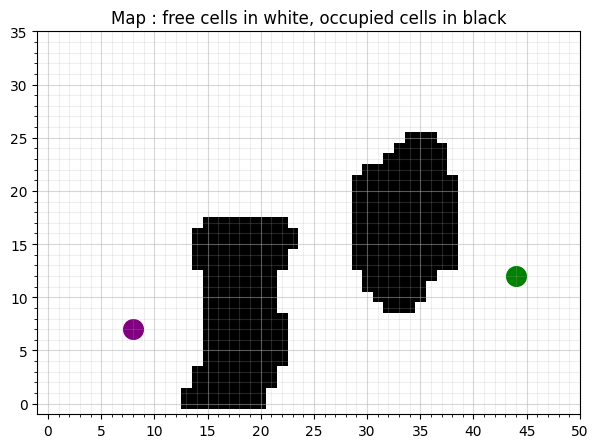

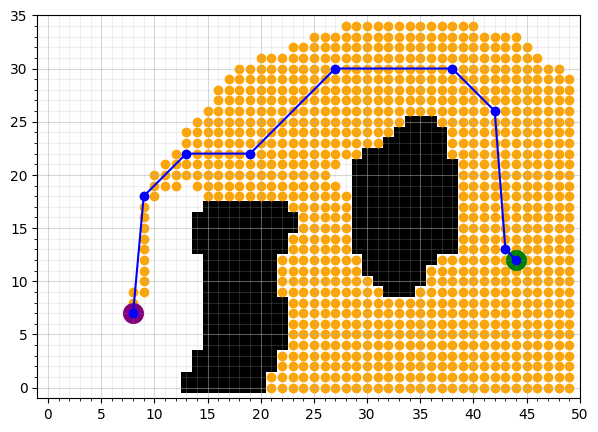

In [4]:
#setup
if REFRAME:
    Tmap = vs.get_warp(cap,MAP_SHAPE_MM,20,10)

ret,frame = cap.read()
if ret:
    if REFRAME:
        frame = cv2.warpPerspective(frame,Tmap,MAP_SHAPE_MM)
    fmap = vs.get_grid_fixed_map(frame,MAP_SHAPE_CELL)
    obscont = vs.get_obstacles(frame)
    print("Searching for destination...")
    while True:
        ret,frame = cap.read()
        if ret:
            if REFRAME:
                frame = cv2.warpPerspective(frame,Tmap,MAP_SHAPE_MM)
            ret,destmm = vs.get_destination(frame)
            if ret:
                dest = gn.convert_to_idx([coord / 10.0 for coord in destmm],2)
                dest[1]= 35-dest[1]
                dest = tuple(dest)
                break
            else:
                print("no destination !",end='\r')
        else:
            print("No camera !")
            break
    print("Found destination Point at {} [mm] {} [cells]".format(destmm,dest))
    print("Searching for Robot...")
    while True:
        ret,frame = cap.read()
        if ret:
            if REFRAME:
                frame = cv2.warpPerspective(frame,Tmap,MAP_SHAPE_MM)
            hls_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS_FULL) 
            ret,robpos,orient,pxpcm = vs.get_Robot_position_orientation(hls_frame)
            if ret:
                print("Robot found at {} [mm], {} [rad]".format(robpos,orient))
                break
        else:
            print("No camera !")
            break

start = gn.convert_to_idx(robpos,20)
start[1]= MAP_SHAPE_CELL[1]-start[1]
start = tuple(start)
path = gn.global_final(fmap,start,dest, "8N", VISUALIZE)


robot at [44.09862796 13.26569481], grid coord [44, 13] next checkpoint at[43 13]


robot at [44.12043953 12.30297727], grid coord [44, 12] next checkpoint at[42 26]
robot at [42.56787555 24.96971118], grid coord [42, 24] next checkpoint at[38 30]
robot at [39.61729873 28.83105258], grid coord [39, 28] next checkpoint at[27 30]
robot at [28.81790056 30.39484812], grid coord [28, 30] next checkpoint at[19 22]
Kidnapping detected
Kidnapping detected
Kidnapping detected
Kidnapping detected
Kidnapping detected
Kidnapping detected
Kidnapping detected
Kidnapping detected
Kidnapping detected
Initial Map: 0/3
Map with optimal path
robot at [29.1  8.9], grid coord [29, 8] next checkpoint at[26 11]
robot at [27.61917502 10.44354205], grid coord [27, 10] next checkpoint at[26 18]
Entering Local navigation mode
robot at [26.80074934 15.23912825], grid coord [26, 15] next checkpoint at[13 22]
Entering Local navigation mode
Entering Local navigation mode
Entering Local navigation mode
Entering Local navigation mode
Entering Local navigation mode
Entering Local navigation mode
Enter

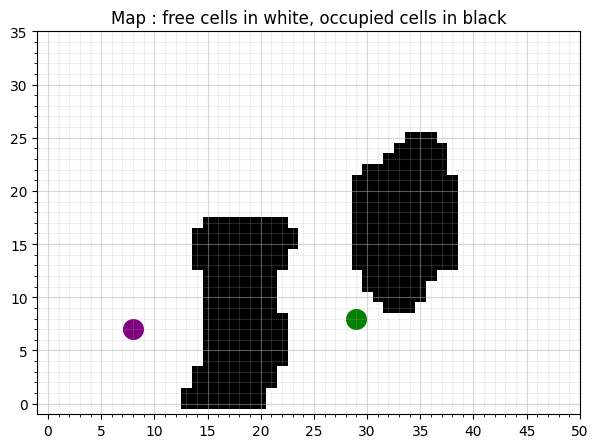

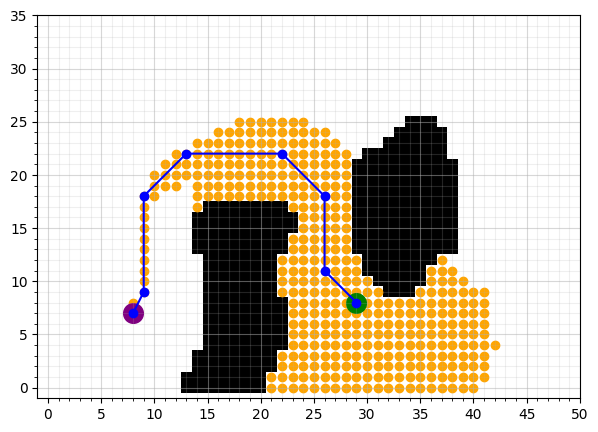

In [5]:
##Main boucle with Kalman Aubin

local_obstacle = False
counter=0
cell_pos_history= []
kidnapping_state = False
check=[]
check_point_prev=np.array([0,0])
Kp = 50
spdPID = 100
start_time = time.time()

state_estimation_prev= np.array([[robpos[0]],[robpos[1]],[orient],[0],[0]])
P_estimation_prev =  np.diag([100, 100, 0.75, 10, 0.75])

while True:
    ret,frame = cap.read()
    if ret:

        if REFRAME:
            frame = cv2.warpPerspective(frame,Tmap,MAP_SHAPE_MM)

        HLS = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS_FULL)

        camgotpos ,robpos,orient, scale = vs.get_Robot_position_orientation(HLS, 5)
        if camgotpos : 

            robpos[1] = MAP_SHAPE_MM[1]- robpos[1]
            orient2 = orient
            if orient <0:
                orient = orient +2*np.pi
            x_est_cam = np.array([robpos[0], robpos[1], orient])
            cell_pos_cam = np.array([x_est_cam[0]/20, x_est_cam[1]/20, orient2])
            cell_pos_history.append(cell_pos_cam)


        ground_values = await th.get_proximity_ground_values(client)
        if(ground_values[0]<300 or ground_values[1]< 300):
            print('Kidnapping detected')
            await th.stop_motor(node)
            kidnapping_state= True

        if ground_values[0]>300 and ground_values[1]>300 and kidnapping_state and camgotpos:

            kidnapping_state = False
            start = gn.convert_to_idx(robpos,20)
            start = tuple(start)
            path = gn.global_final(fmap,start,dest, "8N", VISUALIZE)
            state_estimation_prev = np.array([[robpos[0]],[robpos[1]], [orient], [0], [0]])
            P_estimation_prev =  np.diag([100, 100, 0.75, 10, 0.75])
            counter =0
            check_point_prev=np.array([0,0])
            start_time = time.time()
     
        state_estimation, P_estimation, speed, angular_speed, start_time, angle = await filtering.get_position(state_estimation_prev, P_estimation_prev, start_time,camgotpos,x_est_cam, node )
        state_estimation_prev = state_estimation
        P_estimation_prev = P_estimation

        position = np.array([state_estimation[0].item(), state_estimation[1].item()])
        theta = angle
        position = position / 20.0
        position_array = np.array(position)

        state_history = np.array([position_array[0], position_array[1], theta[0]])
        check.append(state_history)

        check_point, counter = gn.next_checkpoint2(path, position, counter,local_obstacle)
            
        if not kidnapping_state:
            if np.any(check_point_prev != check_point):
                print(f"robot at {position}, grid coord {gn.convert_to_idx(position, 1)} next checkpoint at{check_point}")
                check_point_prev = check_point
                
            if abs(position[0]-path[-1][0])<1 and abs(position[1]-path[-1][1])<1:
                await th.stop_motor(node)
                break

            
            angle_error=  theta-th.compute_angle(gn.convert_to_idx(position,1), path[counter])
            if angle_error > np.pi :
                angle_error = angle_error-2*np.pi
            if angle_error < -np.pi:
                angle_error = angle_error+ 2*np.pi

            
            capthall = pm.hallucinate_map([position[0],position[1],(-orient)],obscont)
            sens = await th.get_proximity_values(client)
            if (sum(sens[i] > 1000 for i in range(0, 5)) > 0):
                local_obstacle = True

            if(local_obstacle):
                print("Entering Local navigation mode")
                await ln.local_navigation2(client,node,[position[0],position[1],(-orient)],obscont)
                
                if(not sum(sens[i] > 1000 for i in range(0, 5)) > 0):
                    await th.motorset(node,100,100)
                    time.sleep(1.5)
                    local_obstacle = False
            #motor control
            else :
                if(angle_error>EPSILON_ANGLE):
                    await th.motorset(node,70,-70)
                elif (angle_error<-EPSILON_ANGLE):
                    await th.motorset(node,-70,70)
                else:
                    speed_l, speed_r = PID.PIDController(Kp,spdPID, angle_error)
                    await th.motorset(node,speed_l,speed_r)
                    

        if VISUALIZE:
            vizu = vs.visualizer(HLS)
            omap =vs.grid_fixedmap_visualizer(fmap.transpose(),MAP_SHAPE_MM)
            obsimg = cv2.merge([omap,omap,omap])
            vizu = cv2.bitwise_or(vizu,obsimg)
            vizu = vs.draw_obstacles_poly(vizu,obscont,(255,255,0),2)
            vizu = cv2.circle(vizu,destmm,20,(50,25,100),4)
            vizu = cv2.addWeighted(vizu,0.5,frame,0.5,0)
            vizu = vs.show_path(vizu,path,20,10)
            vizu = vs.show_Kalman(vizu,state_estimation,P_estimation,10)
            robpos[1] = MAP_SHAPE_MM[1] - robpos[1]
            vizu = vs.paint_robot(vizu,(0,0,200),robpos,orient,pxpcm)
            vizu = pm.hallucinate_map([robpos[0],robpos[1],(-orient)],obscont,vizu)
            videosaver.write(vizu) 
            jcv2.imshow("Map",vizu)
            if jcv2.waitKey(1) & 0xFF == ord('q'):
                await th.stop_motor(node)
                break
        else:
            print("###################################################",end='\r')
            print("pos: {},{:.2f} dest: {} fhal: {}".format(robpos,orient,destmm,capthall),end='\r')
    
    else :
        print("error : camera failure.")
        break

videosaver.release()
jcv2.destroyAllWindows()
await th.stop_motor(node)

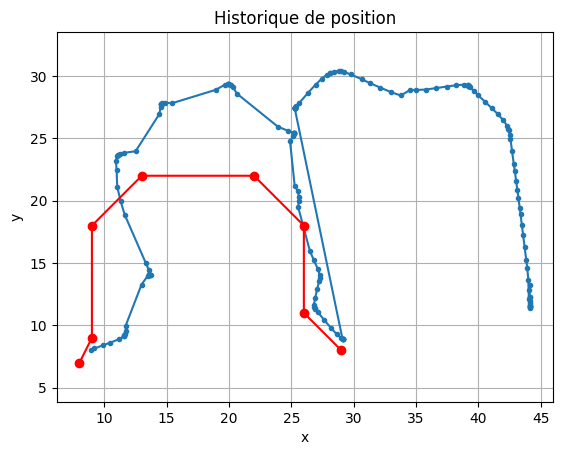

In [6]:

x_values = [coord[0] for coord in check]
y_values = [coord[1] for coord in check]
x_path =   [coord[0] for coord in path]
y_path =  [coord[1] for coord in path]

# Tracer le graphique x en fonction de y
plt.plot(x_values, y_values, marker='.', linestyle='-')
plt.plot(x_path, y_path, marker ='o', color = 'red')
plt.axis('equal')
plt.title('Historique de position')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


In [7]:
await th.stop_motor(node)
node.unlock()

<generator object ClientAsyncNode.unlock at 0x000002B926EA9080>